In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from safety_train_new import Extractor, Adaptor, Classifier, FullModel

from glob import glob
from PIL import Image
import torchvision.transforms as transforms
from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## only image

In [2]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/only_img/multi_extractor_small_dataset_20241228/lr_1e-05_visual_feature_extractor_ViT_LLM_loaded_False/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()


In [68]:
def vision_model_test(model, test_loader, model_type='feature_extractor', LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            data, target = data.cuda(), target.cuda().long()
            if model_type == 'feature_extractor':
                output = model(data)['features']
            else:
                output = model(data)
            # output = model(data)['features']
            all_outputs.append(output)
            all_labels.append(target)
    
    
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_outputs, all_labels

def vision_model_single_image(model, image, model_type='feature_extractor', LLM_model=None):
    model.eval()  # 切换到评估模式
    with torch.no_grad():  # 关闭梯度计算，节省内存
        if LLM_model is not None:
            image = LLM_model([image])
        image = image.cuda().unsqueeze(0)  # 添加batch维度
        if model_type == 'feature_extractor':
            output = model(image)['features']
        else:
            output = model(image)
    return output


In [4]:
# error_panoid = []
# for i, row in data.iterrows():
#     panoid = row["Image_ID"]
#     for angle in [0, 90 ,180, 270]:
#         image_path = f"/data2/cehou/LLM_safety/GSV/HK_imgs/{panoid[0]}/{panoid[1]}/{panoid}_{angle}.jpg"
#         img = Image.open(image_path)
#         img = np.array(img)
#         if img.shape != (300, 400, 3):
#             print(image_path)
#             error_panoid.append(panoid)


In [5]:
# data = pd.read_csv(parameters['placepulse_datapath'])
data = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/finished/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl')
data['label'] = 1
data.rename(columns={"panoid": "Image_ID"}, inplace=True)
error_panoid = {'_ZyueibIbaC6UyhG4WcRAA', 'kXQjqDhu9HnvAdIkKl-37Q'}
data = data[~data['Image_ID'].isin(set(error_panoid))]
data_ls = data[data['label'] != 0]
data_ls.loc[data_ls[data_ls['label'] == -1].index, 'label'] = 0
transform = get_transforms((224,224))
train_num = int(len(data_ls) * 0.6)
valid_num = int(len(data_ls) * 0.2)


LLM_pre_extractor = None
one_dataset = SafetyPerceptionDataset(data[:200], transform=transform, paras=parameters, SVI_type="GSV")
one_loader = torch.utils.data.DataLoader(one_dataset, batch_size=parameters['batch_size'])

total_dataset = SafetyPerceptionDataset(data, transform=transform, paras=parameters, SVI_type="GSV") 
total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=parameters['batch_size'])

extractor = Extractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
adaptor = Adaptor(input_dim=parameters['input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
classifier = Classifier(input_dim=parameters['adaptor_output_dim'], num_classes=parameters['num_classes']) # [128, 2]
model = FullModel(extractor, adaptor, classifier).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load(model_path), strict=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [25]:
feature_extractor = create_feature_extractor(model, return_nodes={'extractor.model.encoder.ln': 'features'})
all_outputs, all_labels = vision_model_test(feature_extractor, one_loader, model_type='feature_extractor')
# valid_outputs, valid_labels = model_test(model, valid_loader)

100%|██████████| 2/2 [00:05<00:00,  2.65s/it]


In [88]:
nodes, _ = get_graph_node_names(model)
print(nodes)

['x', 'extractor.model.getattr', 'extractor.model.getitem', 'extractor.model.getitem_1', 'extractor.model.getitem_2', 'extractor.model.eq', 'extractor.model._assert', 'extractor.model.eq_1', 'extractor.model._assert_1', 'extractor.model.floordiv', 'extractor.model.floordiv_1', 'extractor.model.conv_proj', 'extractor.model.mul', 'extractor.model.reshape', 'extractor.model.permute', 'extractor.model.getattr_1', 'extractor.model.getitem_3', 'extractor.model.extractor_model_class_token', 'extractor.model.expand', 'extractor.model.cat', 'extractor.model.dim', 'extractor.model.eq_2', 'extractor.model._assert_2', 'extractor.model.extractor_model_encoder_pos_embedding', 'extractor.model.add', 'extractor.model.encoder.dropout', 'extractor.model.dim_1', 'extractor.model.eq_3', 'extractor.model._assert_3', 'extractor.model.encoder.layers.encoder_layer_0.ln', 'extractor.model.encoder.layers.encoder_layer_0.self_attention', 'extractor.model.getitem_4', 'extractor.model.encoder.layers.encoder_layer_

In [158]:
print(model.extractor.model.encoder.layers.encoder_layer_11)

Module(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)


In [148]:
print(model.extractor.model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Module(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Module(
      (encoder_layer_0): Module(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): Module(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): Multih

In [159]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 注册钩子函数来提取特征图和梯度
        self.hook_layers()

    def hook_layers(self):
        # 注册前向钩子和反向钩子
        def forward_hook(module, input, output):
            self.activations = output
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        
        # 钩子层
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        # 前向传播
        self.model.eval()
        output = self.model(input_image)
        
        # 反向传播
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward(retain_graph=True)

        # 获取梯度和激活图
        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()

        # 计算每个通道的权重
        weights = np.mean(gradients, axis=(2, 3))[0, :]  # Global average pooling
        cam = np.zeros(activations.shape[2:], dtype=np.float32)

        # 加权特征图
        for i, weight in enumerate(weights):
            cam += weight * activations[0, i, :, :]
        
        # 归一化
        cam = np.maximum(cam, 0)  # ReLU activation
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

    def overlay_cam_on_image(self, input_image, cam):
        # 生成原图和热图叠加的结果
        input_image = input_image.squeeze().cpu().numpy().transpose((1, 2, 0))
        input_image -= np.min(input_image)
        input_image /= np.max(input_image)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlayed_image = cv2.addWeighted(input_image, 0.6, heatmap, 0.4, 0)

        return overlayed_image

# 假设你的模型和目标层已经设置好了

target_layer = model.extractor.model.encoder.layers.encoder_layer_11  # 选定卷积层
gradcam = GradCAM(model, target_layer)
input_image = test_image
target_class = 0  # 目标类别

cam = gradcam.generate_cam(input_image, target_class)
overlayed_image = gradcam.overlay_cam_on_image(input_image, cam)

plt.imshow(overlayed_image)
plt.show()


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/fx/graph_module.py", line 271, in __call__
    return super(self.cls, obj).__call__(*args, **kwargs)  # type: ignore[misc]
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1533, in _call_impl
    return forward_call(*args, **kwargs)
  File "<eval_with_key>.337", line 8, in forward
    getitem_3 = getattr_1[3];  getattr_1 = None
IndexError: tuple index out of range

Call using an FX-traced Module, line 8 of the traced Module's generated forward function:
    getitem_2 = getattr_1[2]
    getitem_3 = getattr_1[3];  getattr_1 = None

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
    eq = getitem_2 == 224

    _assert = torch._assert(eq, 'Wrong image height! Expected 224 but got Proxy(getitem_2)!');  eq = None



IndexError: tuple index out of range

In [160]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers = model.extractor.model.encoder.layers.encoder_layer_11  # 选定卷积层
target_class = 0  # 目标类别

with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#   print(input_tensor.shape)
#   print(targets)
  grayscale_cam = cam(input_tensor=test_image, targets=target_class)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

TypeError: __init__() got an unexpected keyword argument 'target_layers'

In [32]:
import torchvision.transforms as T

output_feature = all_outputs[0,1:,0].reshape(14, 14)
output_feature_tensor = torch.tensor(output_feature)
resize_transform = T.Resize((224, 224))
output_feature_resized = resize_transform(output_feature_tensor.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
output_feature_resized = output_feature_resized.cpu().numpy()
print(output_feature_resized.shape)  # Should print (224, 224)

(224, 224)


/tmp/ipykernel_74374/1735474179.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_feature_tensor = torch.tensor(output_feature)
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.war

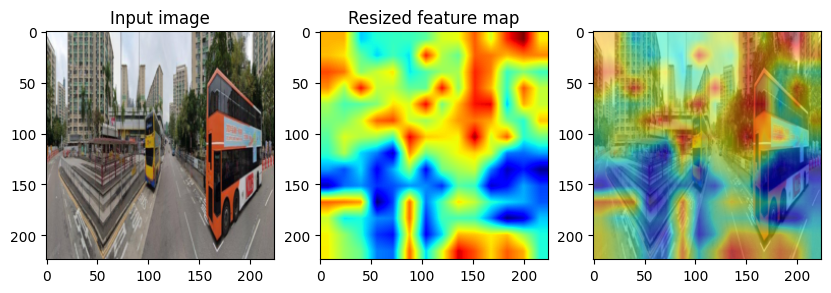

In [49]:
idx = 1

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(original_img[idx].permute(1,2,0))
ax[0].set_title('Input image')
ax[1].imshow(output_feature_resized, cmap='jet')
ax[1].set_title('Resized feature map')
ax[2].imshow(original_img[idx].permute(1, 2, 0).cpu().numpy())
ax[2].imshow(output_feature_resized, cmap='jet', alpha=0.5)  # 使用alpha参数来调整透明度

<Axes: >

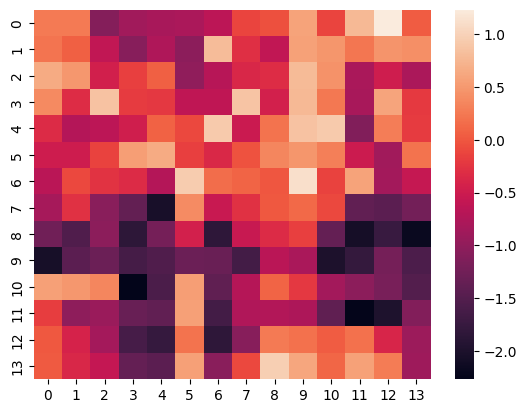

In [26]:
sns.heatmap(all_outputs[0,1:,0].reshape(14, 14).cpu().numpy())

In [21]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [extractor.model.encoder.ln]
input_tensor = next(iter(total_loader))[0]
rgb_img = input_tensor[0].permute(1, 2, 0).cpu().numpy()

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(1)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

AttributeError: 'NoneType' object has no attribute 'shape'

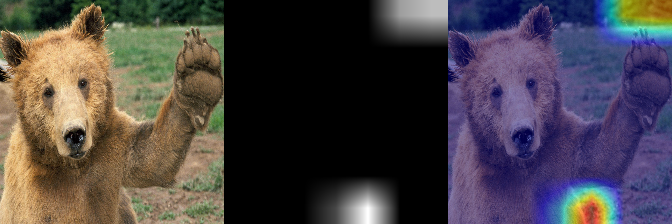

In [12]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(123)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Ensure the model is already defined and loaded
# Ensure the total_loader is already defined

target_layers = [model.adaptor.layer_norm]
print(target_layers)
first_batch = next(iter(total_loader))
input_tensor = first_batch[0][:2]  # Assuming the first element in the batch is the tensor

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(1)]

# Convert input tensor to numpy array for visualization
rgb_img = input_tensor.cpu().numpy().transpose(0, 2, 3, 1)[0]

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    print(grayscale_cam.shape)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    # You can also get the model outputs without having to redo inference
    model_outputs = cam.compute_cam_per_layer(input_tensor=input_tensor, targets=targets)

[LayerNorm((256,), eps=1e-05, elementwise_affine=True)]
An exception occurred in CAM with block: <class 'IndexError'>. Message: too many indices for tensor of dimension 2


In [53]:
targets[0]

In [56]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [model.adaptor.layer_norm]
print(target_layers)
first_batch = next(iter(total_loader))
input_tensor = first_batch[0]  # Assuming the first element in the batch is the tensor

# We have to specify the target we want to generate the CAM for.
targets = [1]

# Convert input tensor to numpy array for visualization
rgb_img = input_tensor.cpu().numpy().transpose(0, 2, 3, 1)[0]

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result


# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  print(grayscale_cam.shape)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

[LayerNorm((256,), eps=1e-05, elementwise_affine=True)]


An exception occurred in CAM with block: <class 'IndexError'>. Message: too many indices for tensor of dimension 2


In [ ]:
# grad cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers = [nodes[-2]]

# GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)



AttributeError: 'str' object has no attribute 'register_forward_hook'

In [9]:
all_outputs_normalized = F.softmax(all_outputs, dim=1)
final_outputs = all_outputs_normalized[:,0]* 0 + all_outputs_normalized[:,1] * 10
final_outputs = final_outputs.cpu().numpy()

In [10]:
final_outputs

array([3.5435429, 5.6019406, 2.92631  , ..., 2.5145032, 4.6804957,
       1.1790354], dtype=float32)

<Axes: ylabel='Density'>

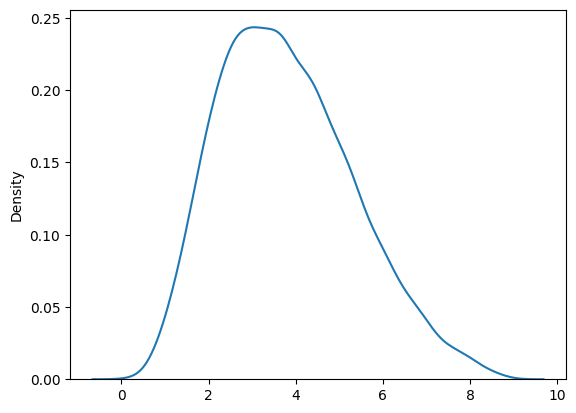

In [11]:
import seaborn as sns
sns.kdeplot(final_outputs)

In [22]:
data['final_outputs'] = final_outputs

In [36]:
data['log_final_outputs'] = np.log(data['final_outputs'])
data['log_score'] = np.log(data['Score'])

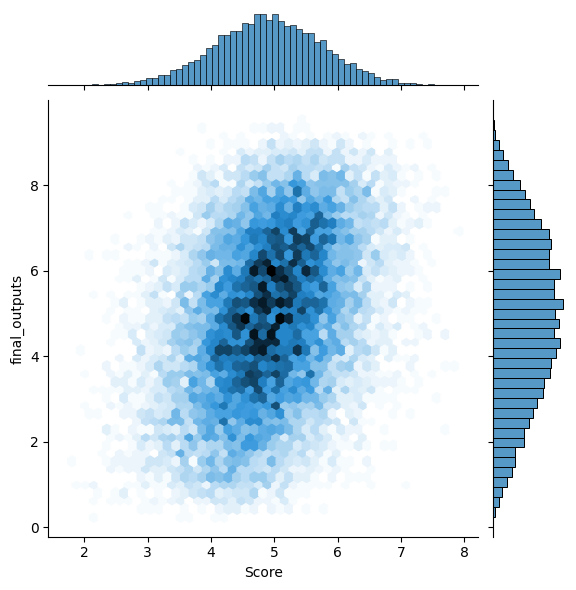

In [46]:
# sns.scatterplot(data=data, x='Score', y='final_outputs')
# sns.jointplot(data=data, x='Score', y='final_outputs', line_kws={"label":f"R2 Score: {r2_score(data['Score'], data['final_outputs']):.2f}"})
sns.jointplot(data=data, x='Score', y='final_outputs', kind='hex')
# plt.legend()

,Unnamed: 0,Image_ID,lat,lon,year,month,id,label
0,0,KtHXnMKIroDc_BK-EePEww,22.310002,114.171100,2009.0,1.0,10,1
1,1,uaWZV0lCAQRN4qCbvBy-uQ,22.310017,114.171079,2009.0,9.0,10,1
2,2,z39LXK-I0_FXEzPSFD4QUQ,22.309992,114.171083,2011.0,2.0,10,1
3,3,iN2ZLjRQCcddBoZLzXwRWA,22.309993,114.171079,2011.0,8.0,10,1
4,4,ZU_JDaoWqgp1wFT9Z_WB5Q,22.310023,114.171109,2017.0,1.0,10,1
...,...,...,...,...,...,...,...,...
683196,683196,WbJQrhfs_OiojpcIkf_YbA,22.434206,114.024910,NaN,NaN,23511,1
683197,683197,QyXxNVkfd4j8ampaLEYIyg,22.434200,114.024810,NaN,NaN,23511,1
683198,683198,EEshehKUF9nHwvYKQfjwuA,22.434916,114.025036,NaN,NaN,23511,1
683199,683199,AktfR4y5OH5ve5fbGwwnOg,22.434748,114.025051,NaN,NaN,23511,1


In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from multimodal_safety_train import ImageExtractor, TextExtractor, Adaptor, Classifier, Mixer, MultiModalModel

import pandas as pd
from glob import glob
from PIL import Image
import torchvision.transforms as transforms
# from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torch.utils.data import Dataset

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [9]:
root_path = "/data2/cehou/LLM_safety/LLM_models/safety_perception_model/multimodal/diff_concat_20241229/model_baseline_lr_1e-05_adaptor_output_dim_512_mix_process_concat/"
model_path = glob(f"{root_path}*.pt")[0]

parameters_path = glob(f"{root_path}*.csv")[0]
parameters = pd.read_csv(parameters_path)
parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
parameters = parameters.iloc[0].to_dict()

class MultimodalSafetyPerceptionDataset(Dataset):
    def __init__(self, data, tokenizer=None, transform=None, paras=None,SVI_type='placepulse'):
        """
        Args:
            data (list or np.array): List or array of data samples.
            labels (list or np.array): List or array of labels corresponding to the data samples.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        # self.captions = list(self.data['text_description_short'])   
        if tokenizer == 'Bert':
            self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
        elif tokenizer == 'GPT2':
            self.tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
        elif tokenizer == 'DistilBert':
            self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        self.transform = transform

        self.img_path = "/data2/cehou/LLM_safety/PlacePulse2.0/photo_dataset/final_photo_dataset/"
        self.paras = paras
        self.SVI_type = SVI_type

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):        
        # image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
        # image = Image.fromarray(image)
        if self.SVI_type == 'placepulse':
            image_path = f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"
            image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
        elif self.SVI_type == 'GSV':
            image_id = self.data.iloc[idx]['Image_ID']
            for i,angle in enumerate([0, 90, 180, 270]):
                image_path = f"{self.img_path}/{image_id[0]}/{image_id[1]}/{image_id}_{angle}.jpg"
                if i == 0:
                    image = np.array(Image.open(image_path))
                else:
                    image = np.concatenate((image, np.array(Image.open(image_path))), axis=0)
        if self.paras['train_type'] == 'classification':
            label = self.data.iloc[idx]["label"]
            # label = label * 100 // 5
        elif self.paras['train_type'] == 'regression':
            label = self.data.iloc[idx]["Score"]
            
        if self.transform:            
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        tokenized_text = self.tokenizer(
            self.data.iloc[idx]["text_description_gender"], padding=True, truncation=True, max_length=512
        )
        encoded_descriptions =  torch.tensor(tokenized_text['input_ids']).float() 
        attention_mask = torch.tensor(tokenized_text['attention_mask']).float()
        # Pad the sequence with zeros to make it 512 in length

        padding_length = 512 - len(encoded_descriptions)
        if padding_length > 0:
            encoded_descriptions = torch.cat((encoded_descriptions, torch.zeros(padding_length)), dim=0)
            attention_mask = torch.cat((attention_mask, torch.zeros(padding_length)), dim=0)
        elif padding_length < 0:
            encoded_descriptions = encoded_descriptions[:512]
            attention_mask = attention_mask[:512]

        # encoded_descriptions转换为long
        # encoded_descriptions = torch.nn.Linear(encoded_descriptions.size(0), 512)(encoded_descriptions)

        return image, (encoded_descriptions, attention_mask), label

def get_transforms(resize_size):
    return transforms.Compose(
        [
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )    


def model_test(model, test_loader, LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_outputs = []
    all_labels = []
    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, target, _ in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            # Ensure all images have 3 channels
            data, target = data.cuda(), target.cuda().long()
            output = model(data)
            # output = model(data)['features']
            all_outputs.append(output)
            all_labels.append(target)
            
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_outputs, all_labels

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_extractor = ImageExtractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
text_extractor = TextExtractor(pretrained_model=parameters['text_feature_extractor']) # [128, 768]
image_adaptor = Adaptor(input_dim=parameters['image_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
text_adaptor = Adaptor(input_dim=parameters['text_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='text') # [128, 256]
mixer = Mixer(output_dim=parameters['mixer_output_dim'], process=parameters['mix_process']) # [128, 512]
classifier = Classifier(input_dim=parameters['mixer_output_dim'], num_classes=parameters['num_classes']) # [128, 2]
model = MultiModalModel(image_extractor, text_extractor, image_adaptor, text_adaptor, mixer, classifier).to(device)

# Load the saved model parameters
model.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)

<All keys matched successfully>

In [11]:
aaa = pd.read_pickle("/data2/cehou/LLM_safety/img_text_data/dataset_30_female_HongKong_traffic accident_GSV_all_4974.pkl")

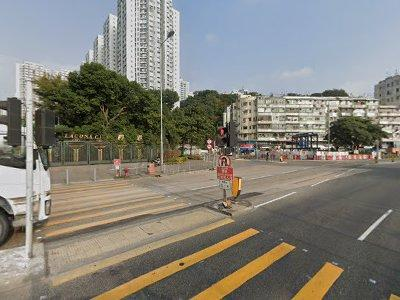

In [38]:
from PIL import Image

panoid = HK_data.iloc[12]['panoid']
img_path = f"/data2/cehou/LLM_safety/GSV/HK_imgs/{panoid[0]}/{panoid[1]}/{panoid}_90.jpg"
img = Image.open(img_path)
img

In [ ]:
import pandas as pd
import geopandas as gpd
female = pd.read_csv("/data2/cehou/LLM_safety/HK_shp_files/30_males/30_females.csv")
male = pd.read_csv("/data2/cehou/LLM_safety/HK_shp_files/30_males/30_males.csv")
baseline = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")
baseline['gender'] = 'baseline'
baseline = baseline.rename(columns={'final_outp':'final_outputs'})

In [38]:
concated = pd.concat([male[['Image_ID','gender', 'final_outputs']],
           female[['Image_ID','gender', 'final_outputs']],
           baseline[['Image_ID','gender', 'final_outputs']]]).reset_index(drop=True)


<Axes: xlabel='final_outputs', ylabel='Density'>

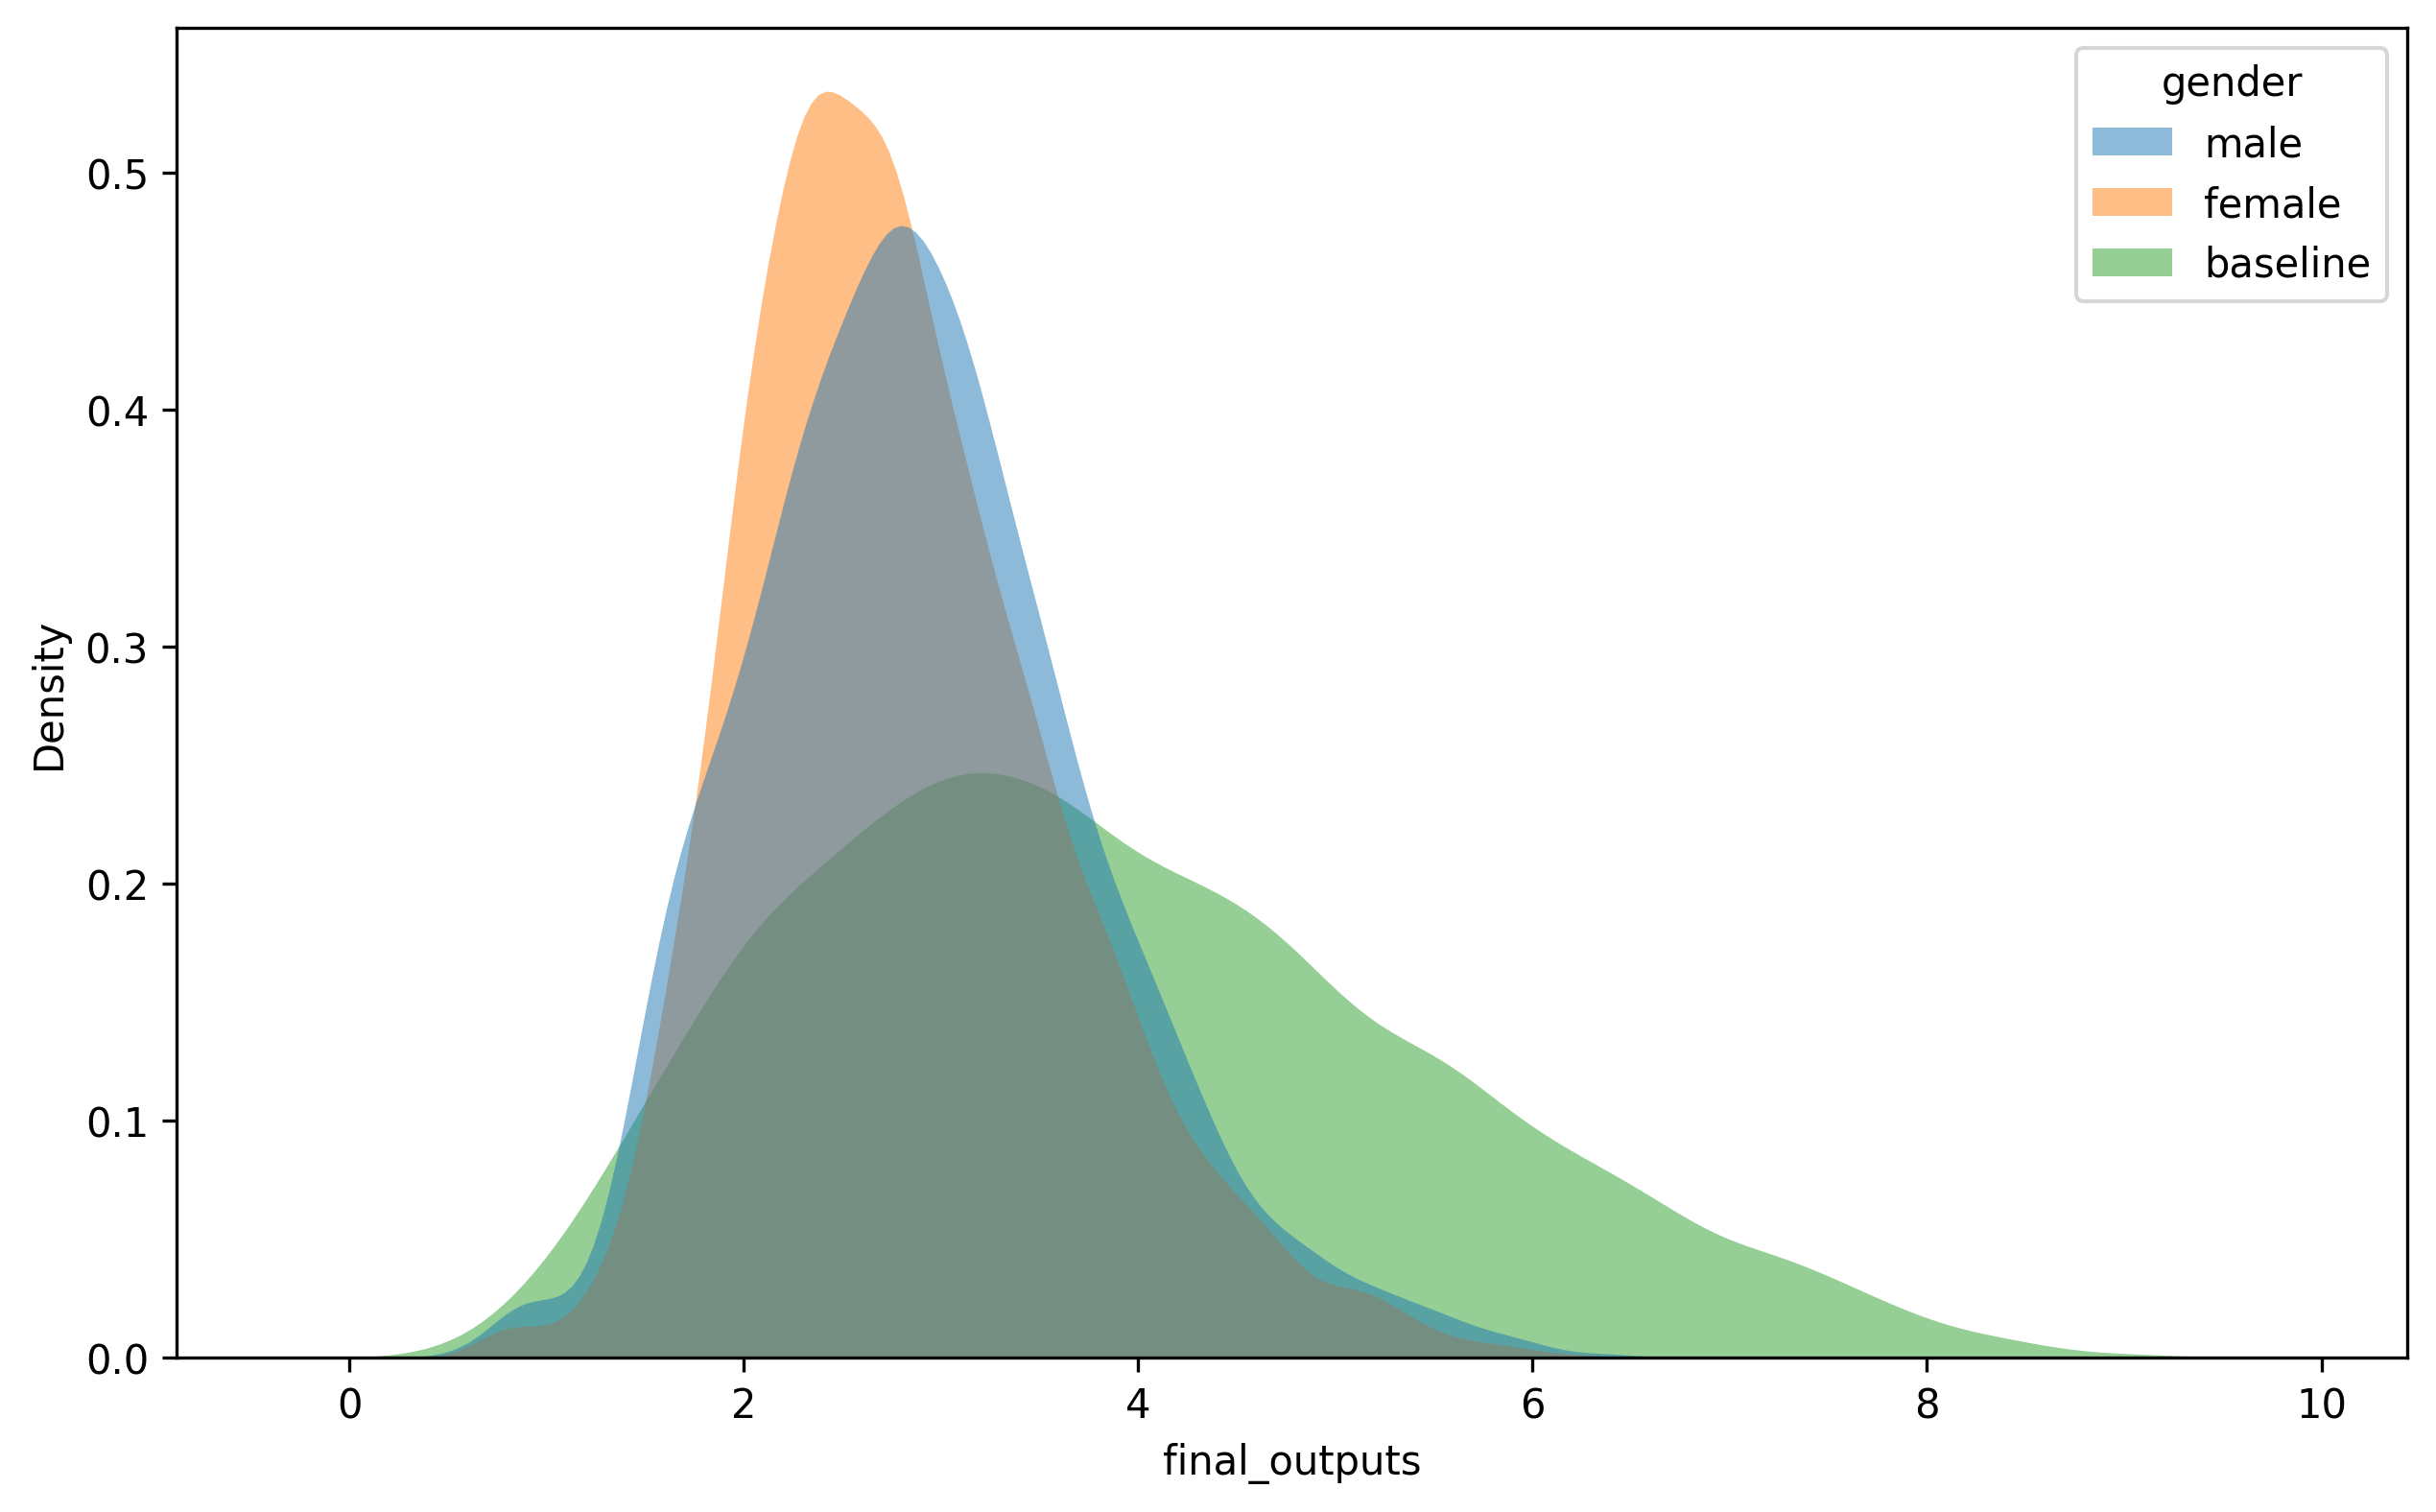

In [48]:
fig, ax = plt.subplots(figsize=(10,6),dpi=300)
sns.kdeplot(
   data=concated, x="final_outputs", hue="gender",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, ax=ax
)

In [12]:
import pandas as pd
HK_data = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl')
HK_data

,GSV_idx,panoid,age,gender,location,event,text_description_all,text_description_age,text_description_gender,text_description_location
0,0,pLuKvPlHrMPC7HbiwdWJsQ,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old individual, several factors ...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...
1,1,9N3G-AjC5a_k_cjbYWTuXQ,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
2,2,vBpRyVLbY1WpqvrM11TCaw,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...
3,3,ksvoYZaPS1tOj9flVw2rPg,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old individual, several factors ...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
4,4,WkHeZe_Exxcwry_UbS7bZw,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
...,...,...,...,...,...,...,...,...,...,...
4707,4984,B6jXBp8HViBTNANUascVbg,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For 30, the factors in the image that could im...",When evaluating the safety perception of speci...,When discussing the safety perception in Hong ...
4708,4985,E1hFilX1FmwMioq1o-hgKw,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old individual, several factors ...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...
4709,4986,dqEW3eJiJmJJgIIuFD2PjQ,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...
4710,4987,UzH6unzGLtuSsTtOYYvfXA,30,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For a 30-year-old, several factors in the imag...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...


In [5]:
HK_data.iloc[0]['text_description_all'][0]

'[INST]  \n["Please design a car accident-focused street safety perception system list briefly and include different information that people pay attention to in street perception by looking around the built environment (elements of the urban environment that Street View images can capture). Please pay special attention to the fact that people of different ages and genders may have different perceptions and reactions. Note that we cannot provide subjective information about residents\' personal experiences, so look for key points from the objective environment, please answer this question within 300 words."] [/INST] Designing a car accident-focused street safety perception system involves considering various elements of the urban environment that can be captured in Street View images. Here are some key points to consider:\n\n1. **Traffic Signs and Signals**: These are crucial for regulating traffic and ensuring safety. In the image, there are traffic lights and signs that provide guidan

In [10]:
HK_data = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/dataset_30_male_HongKong_traffic accident_GSV_2000_all_4712.pkl')
HK_data['label'] = 1
HK_data.rename(columns={'panoid':'Image_ID'}, inplace=True)
HK_data = HK_data[~HK_data['Image_ID'].str.startswith('AF1Q')]
transform = get_transforms((224,224))
parameters['batch_size'] = 256
HK_dataset = MultimodalSafetyPerceptionDataset(HK_data, transform=transform, paras=parameters, SVI_type="GSV")
HK_loader = torch.utils.data.DataLoader(HK_dataset, batch_size=parameters['batch_size'])
all_outputs, all_labels = model_test(model, HK_loader)

# HK_data = pd.read_pickle(HK_dataset)
# HK_data.to_csv('/data2/cehou/LLM_safety/PlacePulse2.0/HK_metadata.csv')

KeyError: 'text_description_short'

In [ ]:
all_outputs_normalized = F.softmax(all_outputs, dim=1)
final_outputs = all_outputs_normalized[:,0]* 0 + all_outputs_normalized[:,1] * 10
final_outputs = final_outputs.cpu().numpy()
HK_data['final_outputs'] = final_outputs

In [3]:
import geopandas as gpd
HK_safety_perception_sampled = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")


<Axes: >

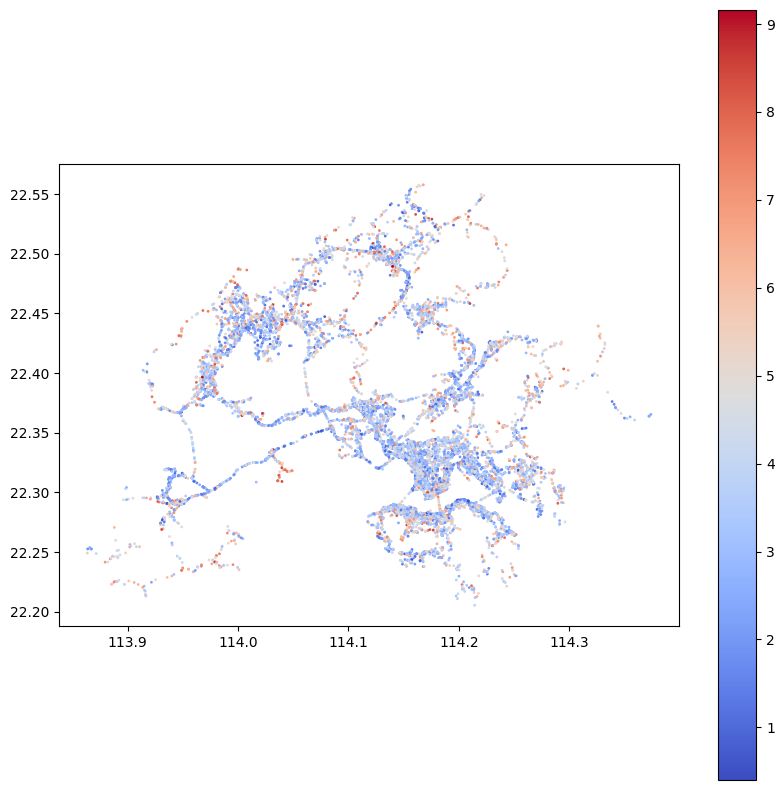

In [7]:
HK_safety_perception_sampled.plot(column='final_outp', cmap='coolwarm', legend=True, markersize=1, figsize=(10,10))

In [ ]:
HK_roads = gpd.read_file("/data_nas/GoogleSV/metadata/China/HongKong/edges.shp")
HK_safety_perception_sampled = gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")
HK_roads = HK_roads.reset_index().rename(columns={'index':'id'})
# HK_safety_perception_sampled.drop(['geometry'], axis=1, inplace=True)
HK_road_merge = HK_safety_perception_sampled.merge(HK_roads[['id', 'geometry']], on='id', how='left')
HK_road_merge = HK_road_merge.drop(['Unnamed_ 0','geometry_x'],axis=1).rename(columns={'geometry_y':'geometry'})

In [58]:
# Group by 'id' and calculate the mean of 'final_outp'
average_final_outp = HK_road_merge.groupby('id')['final_outp'].mean().reset_index()

# Rename the column to indicate it's an average
average_final_outp.rename(columns={'final_outp': 'average_final_outp'}, inplace=True)
HK_road_merge_new = HK_road_merge.merge(average_final_outp, on='id', how='inner')
HK_road_merge_new = gpd.GeoDataFrame(HK_road_merge_new, crs='EPSG:4326', geometry='geometry')
HK_road_merge_new.drop_duplicates(subset=['id'], inplace=True)

In [63]:
HK_road_merge_new.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline_roads.shp")

/tmp/ipykernel_12116/3714306485.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  HK_road_merge_new.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline_roads.shp")


In [52]:
import geopandas as gpd
HK_data_gpd = gpd.GeoDataFrame(HK_data, geometry=gpd.points_from_xy(HK_data['lon'], HK_data['lat']))
HK_data_gpd.set_crs(epsg=4326, inplace=True)
# HK_data_gpd.to_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")

,Unnamed: 0,Image_ID,lat,lon,year,month,id,label,final_outputs,geometry
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119,POINT (114.12836 22.49864)
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859,POINT (114.26078 22.30919)
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743,POINT (114.15813 22.53986)
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057,POINT (113.97466 22.39433)
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885,POINT (114.19632 22.34371)
...,...,...,...,...,...,...,...,...,...,...
9986,9995,457895D8Y6Mr9hZLc_D0Bg,22.383804,114.196998,NaN,NaN,8618,1,3.138475,POINT (114.19700 22.38380)
9987,9996,fXN95evjM46lxpV1hfNw5g,22.462529,114.104716,2021.0,9.0,21713,1,7.635498,POINT (114.10472 22.46253)
9988,9997,uWW-8MfWvXxT9FS20Czoew,22.380430,113.970491,NaN,NaN,16585,1,1.810967,POINT (113.97049 22.38043)
9989,9998,oLFDyYZb0TbgH4xjc5wGdw,22.363614,114.014050,NaN,NaN,16190,1,5.119205,POINT (114.01405 22.36361)


In [1]:
import geopandas as gpd

gpd.read_file("/data2/cehou/LLM_safety/HK_shp_files/HK_only_img_baseline.shp")

,Unnamed_ 0,Image_ID,lat,lon,year,month,id,label,final_outp,geometry
0,0,LhDzohF2sf0z5MOC8WvTlw,22.498642,114.128360,NaN,NaN,16920,1,3.243119,POINT (114.12836 22.49864)
1,1,viTmwnbfW4rJ67N4uqhqDw,22.309188,114.260781,2019.0,9.0,858,1,2.686859,POINT (114.26078 22.30919)
2,2,Zkc3vyAoKoOpvvvw-HChog,22.539859,114.158126,NaN,NaN,10835,1,2.476743,POINT (114.15813 22.53986)
3,3,O4e3zJoSZrUzeN-FIJk6Yg,22.394328,113.974658,NaN,NaN,20584,1,3.825057,POINT (113.97466 22.39433)
4,4,QxlvY42Xl-2J_wuSQfbIKA,22.343713,114.196322,NaN,NaN,2109,1,2.850885,POINT (114.19632 22.34371)
...,...,...,...,...,...,...,...,...,...,...
9986,9995,457895D8Y6Mr9hZLc_D0Bg,22.383804,114.196998,NaN,NaN,8618,1,3.138475,POINT (114.19700 22.38380)
9987,9996,fXN95evjM46lxpV1hfNw5g,22.462529,114.104716,2021.0,9.0,21713,1,7.635498,POINT (114.10472 22.46253)
9988,9997,uWW-8MfWvXxT9FS20Czoew,22.380430,113.970491,NaN,NaN,16585,1,1.810967,POINT (113.97049 22.38043)
9989,9998,oLFDyYZb0TbgH4xjc5wGdw,22.363614,114.014050,NaN,NaN,16190,1,5.119205,POINT (114.01405 22.36361)


In [80]:
nodes, _ = get_graph_node_names(model)
# print(nodes)
feature_extracter = create_feature_extractor(model, return_nodes={'adaptor.layer_norm': 'features'})
all_outputs, all_labels = model_test(feature_extracter, train_loader)
valid_outputs, valid_labels = model_test(feature_extracter, valid_loader)

all_outputs, all_labels = all_outputs.cpu().numpy(), all_labels.cpu().numpy()
valid_outputs, valid_labels = valid_outputs.cpu().numpy(), valid_labels.cpu().numpy()

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# 创建随机森林分类器

def ml_classifier(train_data, train_labels, validate_data, validate_labels, ml_tools):
    if ml_tools == 'random forest':
        ml_model = RandomForestClassifier(n_estimators=500, random_state=42)
    if ml_tools == 'svm':
        ml_model = SVC(kernel='rbf', random_state=42) # kernel=‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    if ml_tools == 'logistic':
        ml_model = LogisticRegression(random_state=42)    
    if ml_tools == 'xgboost':
        ml_model = XGBClassifier(n_estimators=500, random_state=42)
    if ml_tools == 'mlp':
        ml_model = MLPClassifier(hidden_layer_sizes=(1024, 512), max_iter=100)
    
    ml_model.fit(train_data, train_labels)
    predictions = ml_model.predict(validate_data)
    accuracy = accuracy_score(validate_labels, predictions)
    print(f"Accuracy: {accuracy:.2f}, R2 score: {r2_score(validate_labels, predictions):.2f}, f1 score: {f1_score(validate_labels, predictions):.2f}")
    print(classification_report(validate_labels, predictions))
    return predictions

predictions = ml_classifier(all_outputs, all_labels, valid_outputs, valid_labels, 'xgboost')

Accuracy: 0.65, R2 score: -0.39, f1 score: 0.67
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       884
           1       0.64      0.70      0.67       869

    accuracy                           0.65      1753
   macro avg       0.65      0.65      0.65      1753
weighted avg       0.65      0.65      0.65      1753



: 

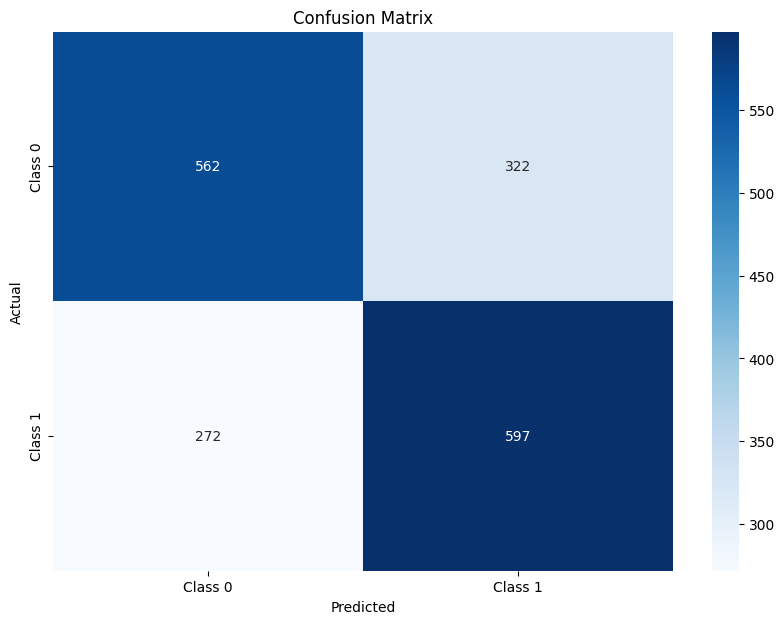

In [110]:
# 计算混淆矩阵
cm = confusion_matrix(valid_labels, predictions)

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


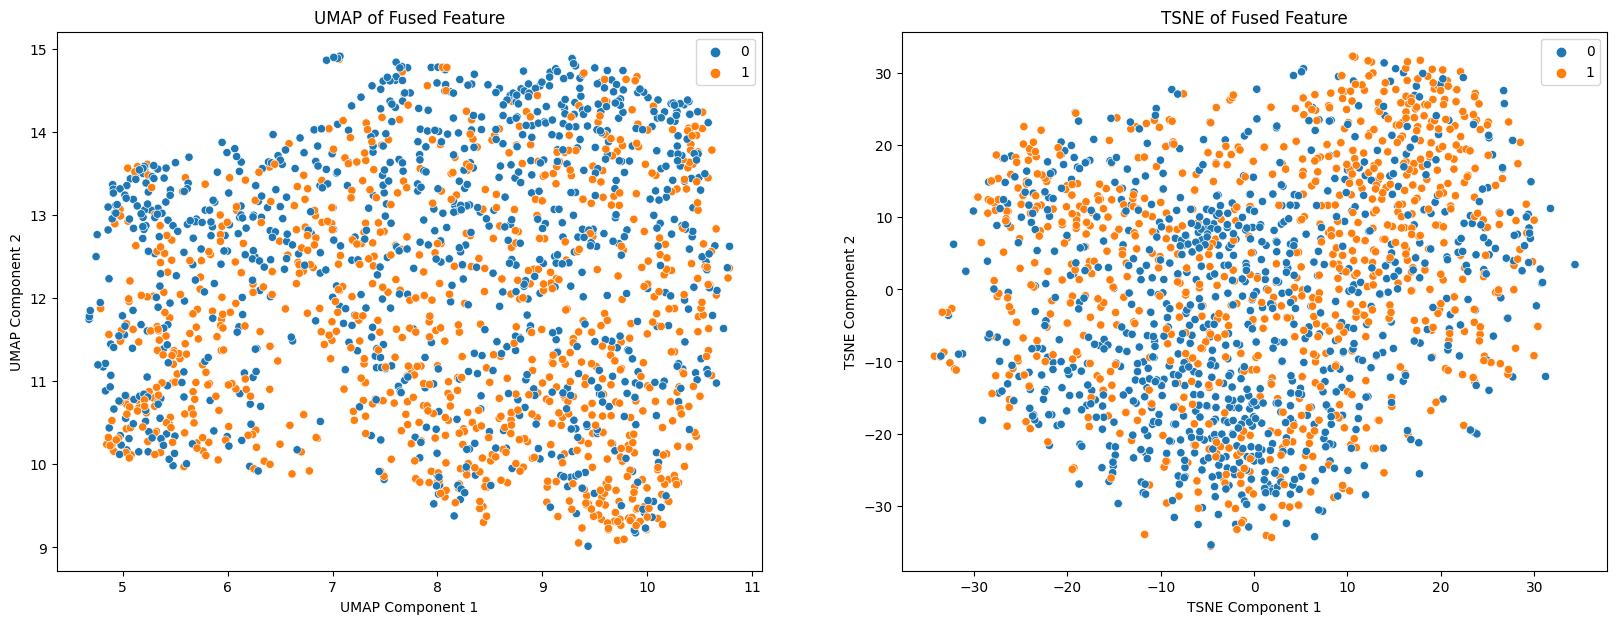

In [99]:
# %pip install umap-learn

import umap.umap_ as umap
from sklearn.manifold import TSNE

# 使用UMAP降维
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(valid_outputs)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(valid_outputs)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(x=umap_results[:,0], y=umap_results[:,1], hue=valid_labels, ax=ax[0])
ax[0].set_title("UMAP of Fused Feature")
ax[0].set_xlabel("UMAP Component 1")
ax[0].set_ylabel("UMAP Component 2")

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=valid_labels, ax=ax[1])
ax[1].set_title("TSNE of Fused Feature")
ax[1].set_xlabel("TSNE Component 1")
ax[1].set_ylabel("TSNE Component 2")
plt.show()


Text(0.5, 1.0, 'PCA of Fused Feature')

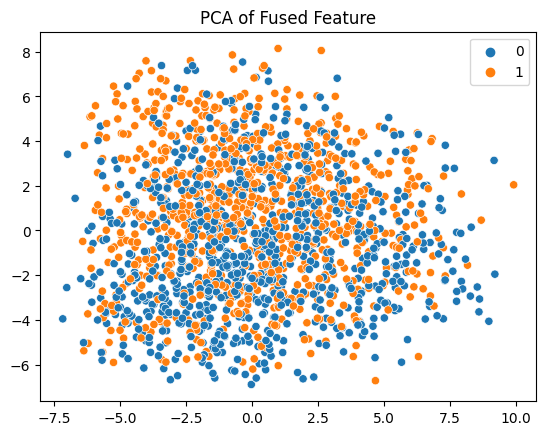

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
combined_feature_pca = pca.fit_transform(valid_outputs)

sns.scatterplot(x=combined_feature_pca[:,0], y=combined_feature_pca[:,1], hue=valid_labels)
plt.title("PCA of Fused Feature")

In [ ]:
# 使用shap计算每个维度的贡献
import shap

# 使用训练数据创建一个 SHAP explainer
explainer = shap.Explainer(mlp_classifier, X_train)
# explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_valid)

shap_values_overall = shap_values[0] + shap_values[1]
shap_values_sum = shap_values_overall.sum(axis=0).reshape(-1, 1)
print(f"image contribution: {shap_values_sum[:256].sum() / shap_values_sum.sum():.02%}, text contribution: {shap_values_sum[256:].sum() / shap_values_sum.sum():.02%}")

# 绘制 SHAP summary plot
# shap.summary_plot(shap_values, X_valid, feature_names=[f'Feature {i}' for i in range(X_valid.shape[1])])

In [ ]:


# # Example usage
# image_encoder = ImageEncoder(cfg_paras)
# text_encoder = TextEncoder(cfg_paras)
# fusion_model = AttentionalFeatureFusion(image_dim=cfg_paras['image_embedding'], text_dim=cfg_paras['text_embedding'], projection_dim=cfg_paras['projection_dim'])

# # Assuming we have image and text inputs
# image_input = torch.randn(1, 3, 112, 112).to(cfg_paras['device'])
# text_input_ids = torch.tensor([[101, 2054, 2003, 1996, 2171, 102]]).to(cfg_paras['device'])
# text_attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]]).to(cfg_paras['device'])

# image_features = image_encoder(image_input)
# text_features = text_encoder(text_input_ids, text_attention_mask)

# fused_features = fusion_model(image_features, text_features)
# print(fused_features)